# RED ID - 824667643 -> Class project - CS 696 - Spring 2020

# Loan risk assessment
## Can you predict if a applicant is capable of repaying the loan ?

## Introduction 

<p>
    Loans are one of the major sources of income of banks. Hence, the primary aim of a banker/lender is to 
    predict if the applicant can completely repay the loan.
</p>

<p>
    The <a href="https://www.kaggle.com/c/home-credit-default-risk" target="_blank"> kaggle competition </a> of Home Credit primary goal is to build a machine learning model that can predict
    the risk involved in approving a loan.
</p>

<p>
    This helps banks increase their revenue by giving loans to genuine clients such there is less chance of default risk and also genuine clients get benefited by getting loans.
</p>

## Dataset description

<p>
    The dataset includes the personal information and credit history of the applicant.
    They are distributed across different csv files such as application_{train|test}.csv, credit_card_balance.csv,
    previous_application.csv.
</p>

<p> 
    I will be focusing more on the basic and first hand information available to the banker about the applicant's
    credit history. This data is populated in the application_{train|test}.csv
</p>

## Business description of the problem

<ul>
    <li> The model should predict if an applicant is capable of repaying the loan. </li>
    <li> The model should avoid/reduce the mistakes of marking an incapable applicant as capable
        to repay the loan.
</ul>
    

## Machine Learning description

<p>
    This problem falls under the region of binary classification (can/cannot repay the loan) of machine learning
    problems.
</p>

<p> 
    The class label in the dataset is either <b> 0 (applicants who were able to pay back their loans) or 1 (applicants who were NOT able to pay back their loans). </b>
</p>

## Performance Metric

<p> 
    As per the business requirement, I can infer that AUC will serve our purpose. So we will use <b> ROC-AUC </b> as the performance metric.
    
</p>

In [27]:
import findspark
from pyspark.sql import SparkSession
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,round,rank,sum,col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LogisticRegression, MultilayerPerceptronClassifier, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## To print everything in a cell, not just the last print statement ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

findspark.init("/Users/ajaysankarreddychintagunta/spark-3.0.0-preview2-bin-hadoop2.7")

# I was getting the following JVM error while creating a spark session.
# Downgrading the pyspark version to 2.3.2 has resolved the issue.
# https://stackoverflow.com/questions/53161939/pyspark-error-does-not-exist-in-the-jvm-error-when-initializing-sparkcontext

### Create a spark session

In [28]:
spark = SparkSession.builder.appName('HomeCreditLoanRiskEstimation').getOrCreate()
loan_history_df = spark.read.csv('application_train.csv', header=True, inferSchema=True)

### Imbalanced class

<p>
    Sk_ID_Curr is the id column which we dont need it in the process #so we get rid of it. 
    And we rename the name of our target variable to "label"
</p>

<p>
    According to the dataset description, label -> 1 indicates that the loan is NOT paid in time, 
    and the label -> 0 indicates that the loan has been repaid well within the time window.
</p>

<p>
    The following counts of each class indicates that 90% of the data belong to class 0 which
    indicates that the classes are imbalanced.
</p>

<p>
    Various techniques are implemented to handle this problem. Will handle this later.
</p>

In [29]:
drop_col = ['SK_ID_CURR']
loan_history_df = loan_history_df.select([
    column for column in loan_history_df.columns if column not in drop_col])
loan_history_df = loan_history_df.withColumnRenamed('TARGET', 'label')
loan_history_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


Training data shape:  (307511, 121)


<Figure size 864x720 with 0 Axes>

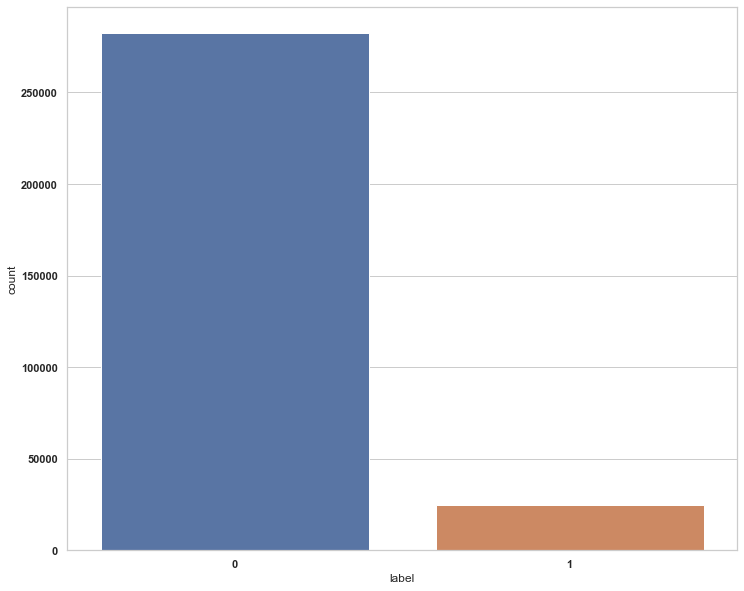

In [30]:
loan_history_df_pandas = loan_history_df.toPandas()
print('Training data shape: ', loan_history_df_pandas.shape)
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=loan_history_df_pandas, order=loan_history_df_pandas['label'].value_counts().index)

In [31]:
loan_history_df_pandas.head(10)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Correlations between features

<p>
    The dataset consists of 120 features.
</p>

In [32]:
correlations = loan_history_df_pandas.corr()['label'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
label                          1.000000
Name: label, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
R

### Data Exploration

##### Utility Fuctions

In [33]:
def classCountsInAnInterval(sub_df, interval):
    """ Returns the total number of instances of  paid/unpaid loans in a given interval """
    """ Input: Dataframe with class counts of the interval passed """
    class0, class1 = 0, 0
    # This check to handle cases where few intervals have only either paid/un-paid loans.
    if np.isscalar(sub_df[sub_df["loan_paid_status"] == 1]):
        class0 = class0 + sub_df[sub_df["loan_paid_status"] == 0]
        class1 = class1 + sub_df[sub_df["loan_paid_status"] == 1]
    else:
        class0 = class0 + int(sub_df[sub_df["loan_paid_status"] == 0]['count'])
        class1 = class1 + int(sub_df[sub_df["loan_paid_status"] == 1]['count'])
    return (class0+class1, class1, interval)

In [34]:
def getIntervalBasedCounts(df, category, no_of_bins=50):
    """ Input: A continous numerical category """
    """ Create bins from the category data points and count total loans, unpaid loans for each bin """
    
    # Create bins #
    continous_numerical_category = category
    binned_columns_name = continous_numerical_category + '_BINNED'
    credit_and_loan_df = pd.DataFrame(data={'loan_paid_status': df['label'], 
                                     continous_numerical_category: df[continous_numerical_category] })
    credit_and_loan_df[binned_columns_name] = pd.cut(credit_and_loan_df[continous_numerical_category], 
                                                     bins = np.linspace(
                                                         min(credit_and_loan_df[continous_numerical_category]), 
                                                         max(credit_and_loan_df[continous_numerical_category]), 
                                                         num = no_of_bins),
                                                     retbins=False)
    
    # Groupby "bin + loan_paid_status" and agg the size of each group.
    # This calculates the paid and unpaid loans counts in each bin.
    credit_and_loan_df = credit_and_loan_df.groupby([binned_columns_name, 'loan_paid_status']).size().to_frame()
    credit_and_loan_df.reset_index(inplace=True)
    credit_and_loan_df.set_index(binned_columns_name, inplace=True)
    
    # Binned column is of  type "Categorical Index" which is not useful in that format. #
    # Converting the bins to string format so that we can plot better based on bin. #
    integer_intervals = list(map(lambda interval: (interval.left,interval.right), credit_and_loan_df.index))
    credit_and_loan_df['integer_intervals'] = list(map(lambda interval: 
                                                       str(int(interval[0])) + '-' + str(int(interval[1])), 
                                                       integer_intervals))
    credit_and_loan_df.reset_index(inplace=True)
    # Drop the bins column of type "Categorical Index"
    credit_and_loan_df = credit_and_loan_df.drop([binned_columns_name], axis=1)
    credit_and_loan_df.set_index('integer_intervals', inplace=True)
    credit_and_loan_df = credit_and_loan_df.rename(columns={0: "count"})
    
    # The dataframe looks like the following
    # bin1 - loan_paid_count
    # bin1 - loan_not_paid_count
    # bin2 - loan_paid_count
    # bin2 - loan_not_paid_count ...
    
    # Calculate the total loans and percentage of unpaid loans in each bin.
    totalCountAndUnpaidCountPerInterval = pd.DataFrame(list(map(lambda interval: 
                                                                classCountsInAnInterval(
                                                                    credit_and_loan_df.loc[interval], interval), 
                                                                list(set(credit_and_loan_df.index)))), 
                                                       columns=['Total Loans', 'Unpaid Loans', 
                                                                continous_numerical_category])
    totalCountAndUnpaidCountPerInterval['percentage_unpaid_loans'] = (totalCountAndUnpaidCountPerInterval['Unpaid Loans'] 
                                                                      / totalCountAndUnpaidCountPerInterval['Total Loans']) * 100
    return totalCountAndUnpaidCountPerInterval

In [35]:
def plotTotalAndUnpaidLoansPerBin(df, featureColumn, totalLoansColumn = "Total Loans", 
                                  unpaidLoansColumn = "Unpaid Loans", top_n_intervals=20):
    """ Plots bins versus total number of loans and unpaid loans """
    sns.set(style="whitegrid")
    df = df.sort_values(totalLoansColumn, ascending=False).head(top_n_intervals)
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Plot the total loans
    sns.set_color_codes("pastel")
    sns.barplot(x=totalLoansColumn, y=featureColumn, data=df, label="Total", color="b")

    # Plot the loans which were unpaid
    sns.set_color_codes("muted")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=40)
    plt.ylabel('ylabel', fontsize=40)

    sns.barplot(x=unpaidLoansColumn, y=featureColumn, data=df, label="Unpaid Loans", color="b")

    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel=featureColumn, xlabel="Number of loans")
    sns.despine(left=True, bottom=True)

In [36]:
def plotPercentageUnpaidLoansPerBin(df, feature, top_n_intervals=20):
    """ Plots bins versus percentage of unpaid loans in that bin """
    font = {
        'weight' : 'bold',
        'size'   : 40
    }
    matplotlib.rc('font', **font)
    f, axes = plt.subplots(1, 1, figsize=(30, 30))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=40)
    plt.ylabel('ylabel', fontsize=40)
    df = df.sort_values('percentage_unpaid_loans',  ascending=False).head(top_n_intervals)
    ax = sns.barplot(x="percentage_unpaid_loans", y=feature, data=df, ax=axes)

#### DAYS_BIRTH

<p>
    The absolute value of the days_birth feature is the age of the applicant in days.
</p>

In [37]:
age_and_loan_df = pd.DataFrame(data={'loan_paid_status': loan_history_df_pandas['label'], 
                                     'age_of_applicant': loan_history_df_pandas['DAYS_BIRTH'] / -365})
age_and_loan_df
age_and_loan_df['age_of_applicant'].describe()

,loan_paid_status,age_of_applicant
0,1,25.920548
1,0,45.931507
2,0,52.180822
3,0,52.068493
4,0,54.608219
...,...,...
307506,0,25.553425
307507,0,56.917808
307508,0,41.002740
307509,1,32.769863


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: age_of_applicant, dtype: float64

<Figure size 1440x720 with 0 Axes>

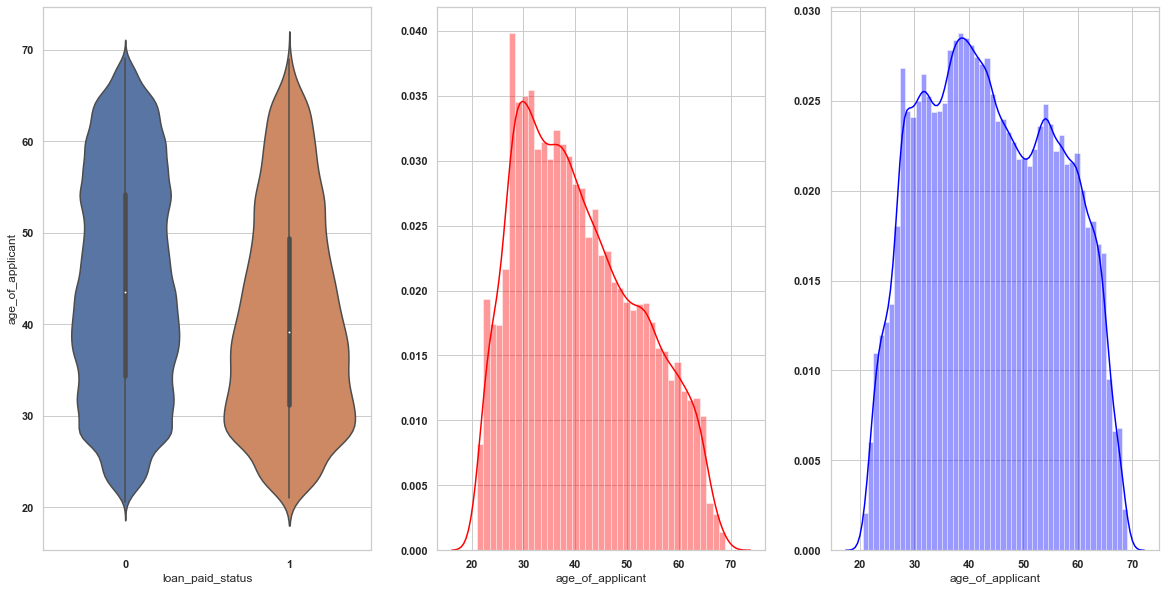

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.violinplot(x='loan_paid_status', y='age_of_applicant', data=age_and_loan_df)
plt.subplot(1,3,2)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==1]['age_of_applicant'], label='loan_not_paid', 
             color='red')
plt.subplot(1,3,3)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==0]['age_of_applicant'], label='loan_paid', 
             color='blue')

<p>
    If you observe above distribution we can say that most people who are not able to repay loan are younger people.
</p>

<p>
    In the loan paid class, applicants in the age group 35-45 years are majority who have paid the loan.
</p>

In [39]:
# Bin the age data
age_and_loan_df['YEARS_BINNED'] = pd.cut(age_and_loan_df['age_of_applicant'], bins = np.linspace(20, 70, num = 11))
age_and_loan_df.head(10)
age_groups  = age_and_loan_df.groupby('YEARS_BINNED').mean()
age_groups

,loan_paid_status,age_of_applicant,YEARS_BINNED
0,1,25.920548,"(25.0, 30.0]"
1,0,45.931507,"(45.0, 50.0]"
2,0,52.180822,"(50.0, 55.0]"
3,0,52.068493,"(50.0, 55.0]"
4,0,54.608219,"(50.0, 55.0]"
5,0,46.413699,"(45.0, 50.0]"
6,0,37.747945,"(35.0, 40.0]"
7,0,51.643836,"(50.0, 55.0]"
8,0,55.065753,"(55.0, 60.0]"
9,0,39.641096,"(35.0, 40.0]"


,loan_paid_status,age_of_applicant
YEARS_BINNED,,
"(20.0, 25.0]",0.123036,23.377522
"(25.0, 30.0]",0.111436,27.822518
"(30.0, 35.0]",0.102814,32.479037
"(35.0, 40.0]",0.089414,37.555913
"(40.0, 45.0]",0.078491,42.459346
"(45.0, 50.0]",0.074171,47.462741
"(50.0, 55.0]",0.066968,52.593136
"(55.0, 60.0]",0.055314,57.491131
"(60.0, 65.0]",0.052737,62.412459


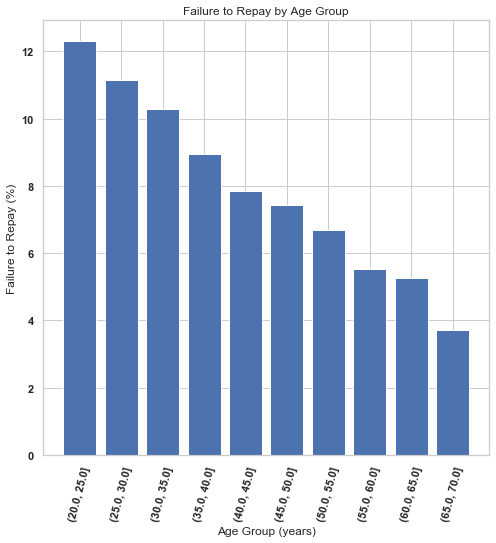

In [40]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['loan_paid_status'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

<p>
    There is a clear trend: younger applicants are more likely to not repay the loan!
</p>

<p>
    This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. The bankers to take precautionary measures to help younger clients pay on time.
</p>

#### AMT_CREDIT

In [41]:
loan_history_df_pandas['AMT_CREDIT'].describe()
credit_amount_and_loan_df = pd.DataFrame(data={'loan paid status': loan_history_df_pandas['label'], 
                                     'credit amount': loan_history_df_pandas['AMT_CREDIT']})
credit_amount_and_loan_df

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

,loan paid status,credit amount
0,1,406597.5
1,0,1293502.5
2,0,135000.0
3,0,312682.5
4,0,513000.0
...,...,...
307506,0,254700.0
307507,0,269550.0
307508,0,677664.0
307509,1,370107.0


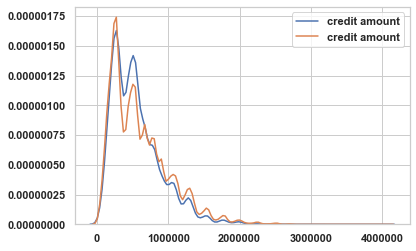

In [42]:
ax = sns.kdeplot(credit_amount_and_loan_df[credit_amount_and_loan_df['loan paid status']==1]['credit amount'])
sns.kdeplot(credit_amount_and_loan_df[credit_amount_and_loan_df['loan paid status']==0]['credit amount'], ax=ax)

#### DAYS_EMPLOYED

In [43]:
day_employed_filtered = pd.DataFrame(loan_history_df_pandas[loan_history_df_pandas['DAYS_EMPLOYED'] <= 0], 
                                     columns=['DAYS_EMPLOYED', 'label'])
day_employed_filtered['YEARS_EMPLOYED'] = day_employed_filtered['DAYS_EMPLOYED'] // -365

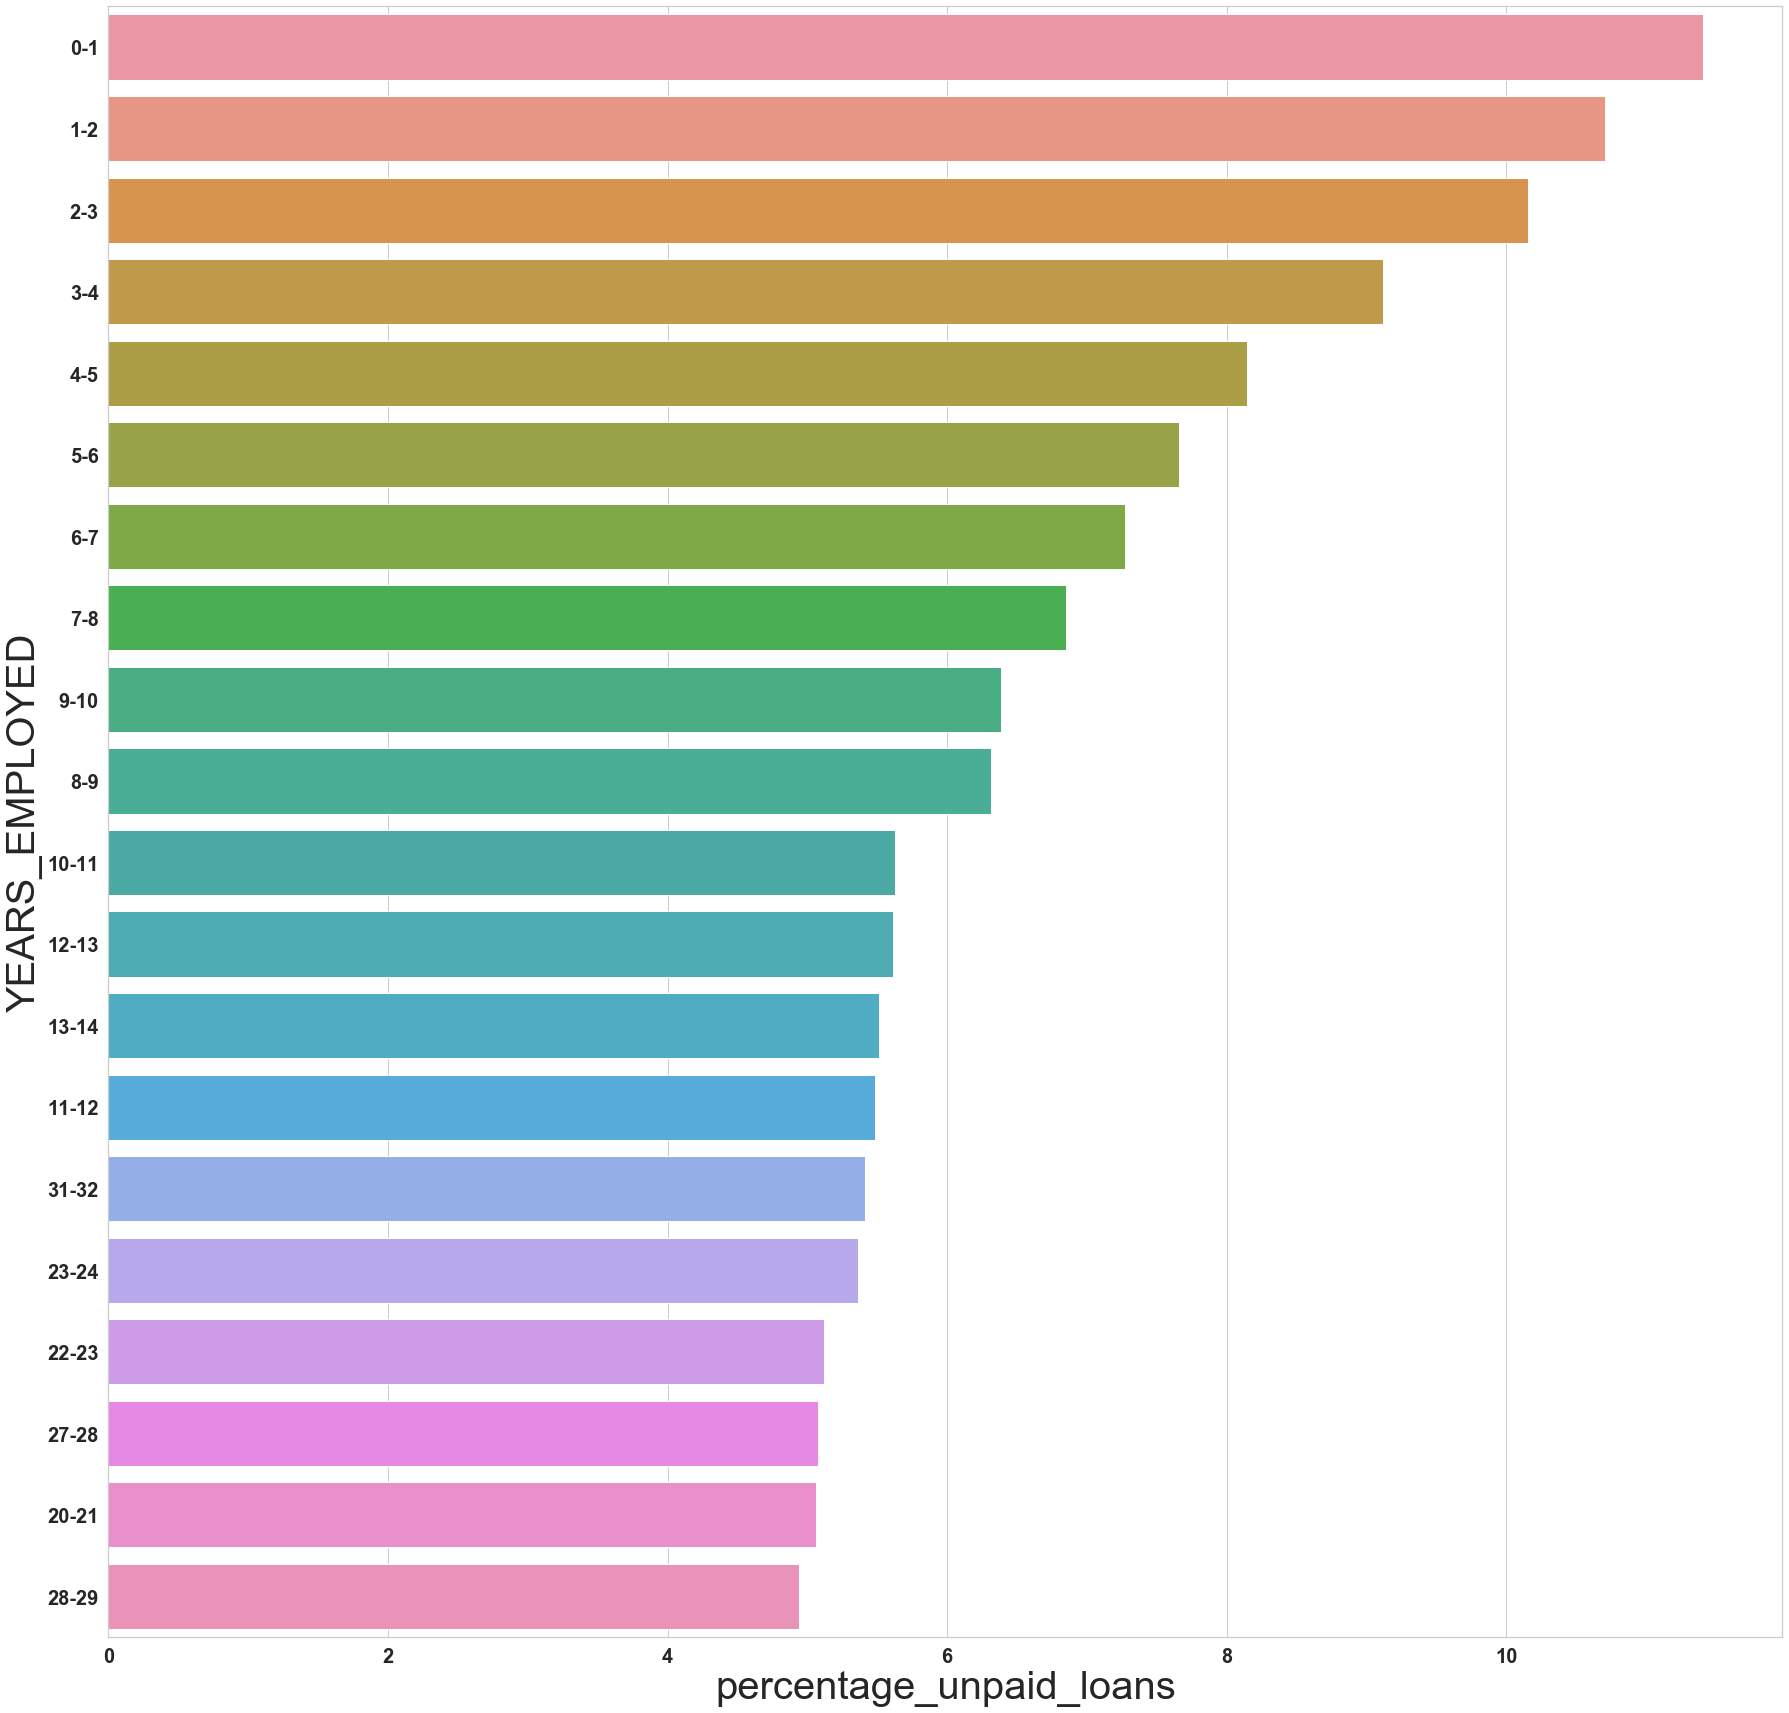

In [44]:
totalCountAndUnpaidCountPerIntervalMonthsEmployed = getIntervalBasedCounts(day_employed_filtered, 
                                                                             "YEARS_EMPLOYED")
plotPercentageUnpaidLoansPerBin(totalCountAndUnpaidCountPerIntervalMonthsEmployed, "YEARS_EMPLOYED")

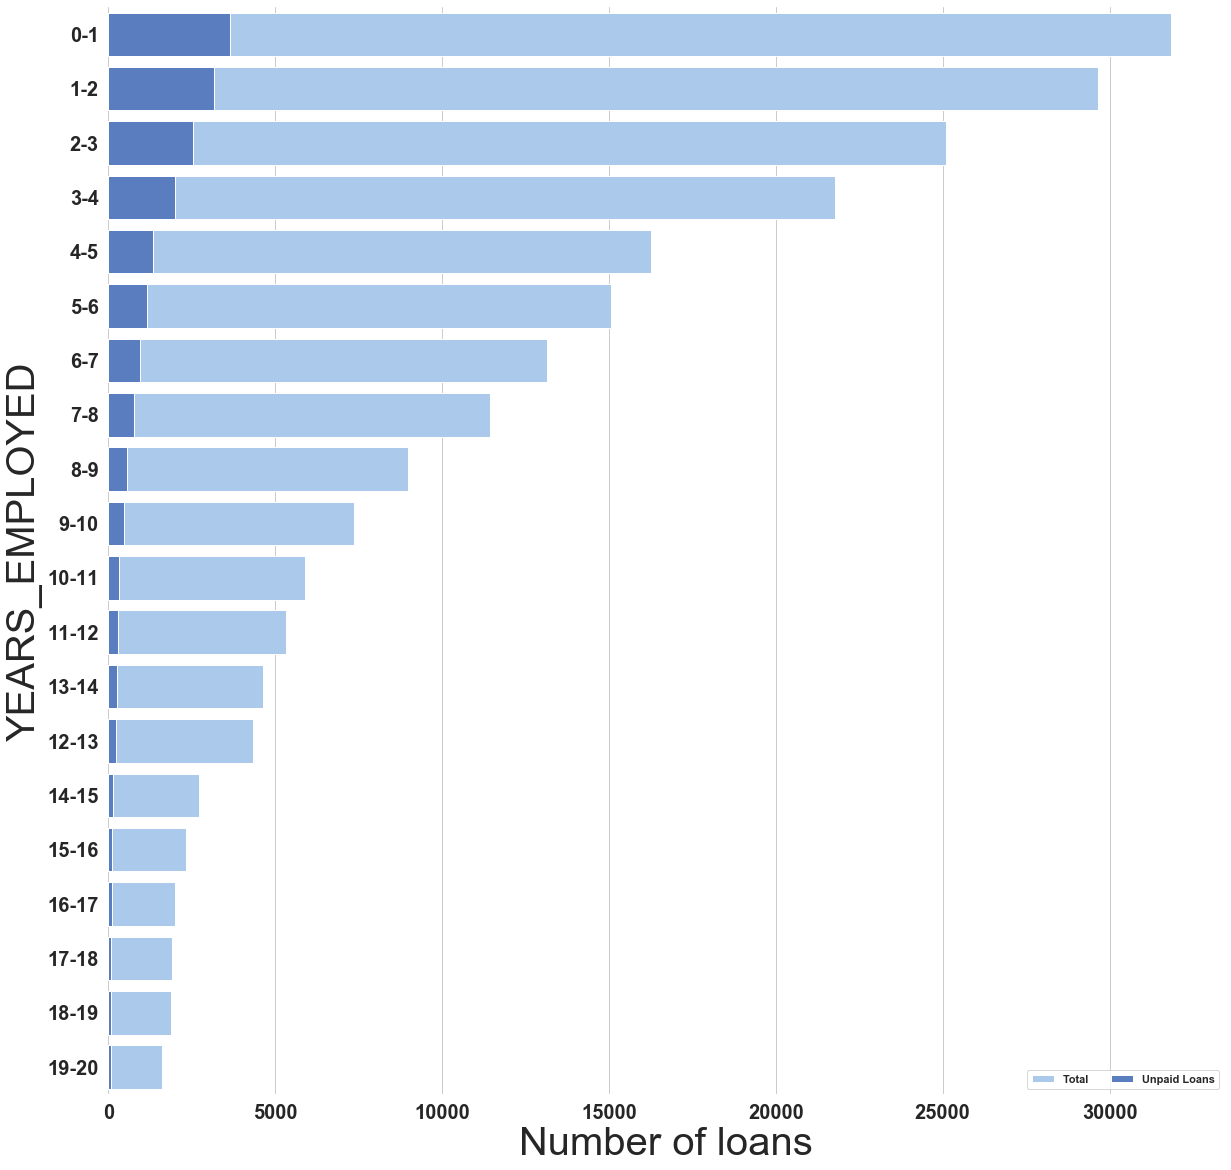

In [45]:
plotTotalAndUnpaidLoansPerBin(totalCountAndUnpaidCountPerIntervalMonthsEmployed, "YEARS_EMPLOYED")

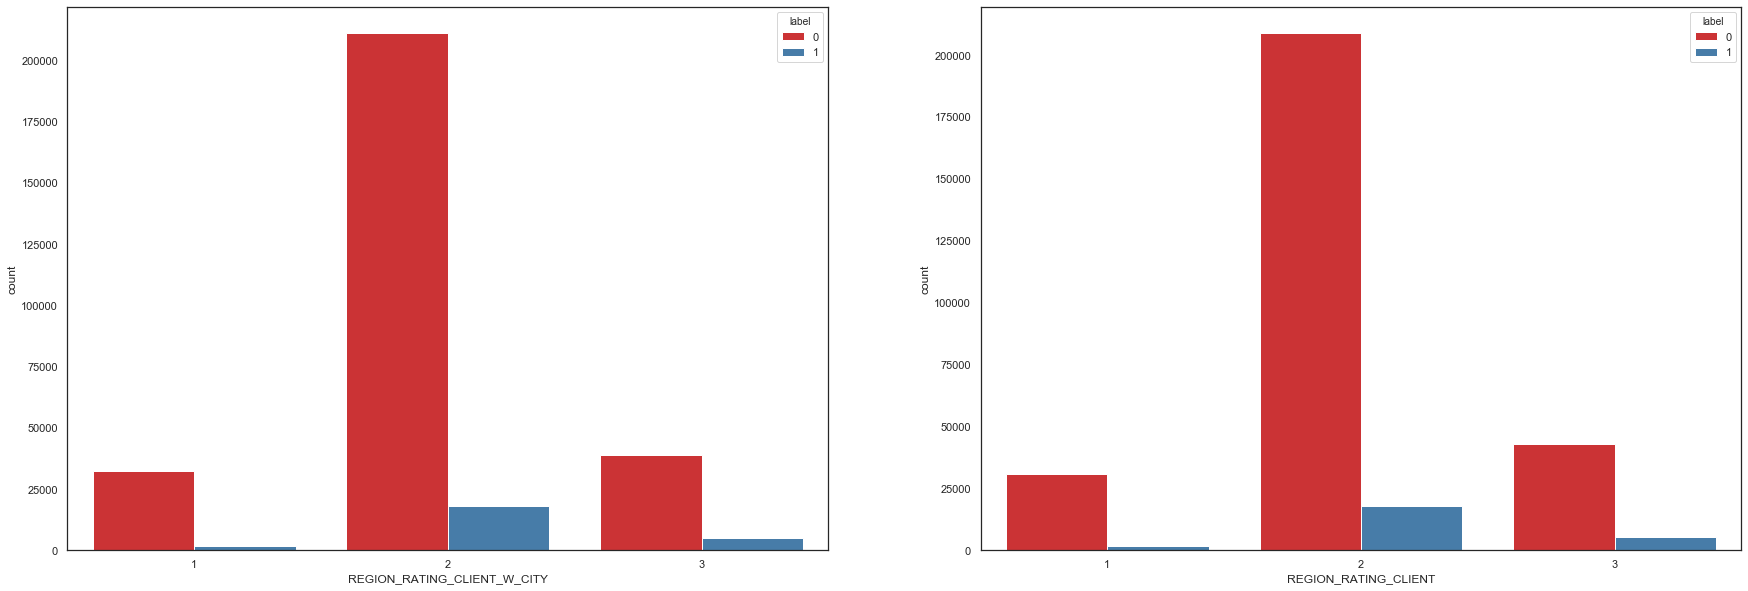

In [16]:
f, axes = plt.subplots(1, 2, figsize=(30, 10))
ax = sns.countplot(x="REGION_RATING_CLIENT_W_CITY", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[0])
ax = sns.countplot(x="REGION_RATING_CLIENT", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[1])

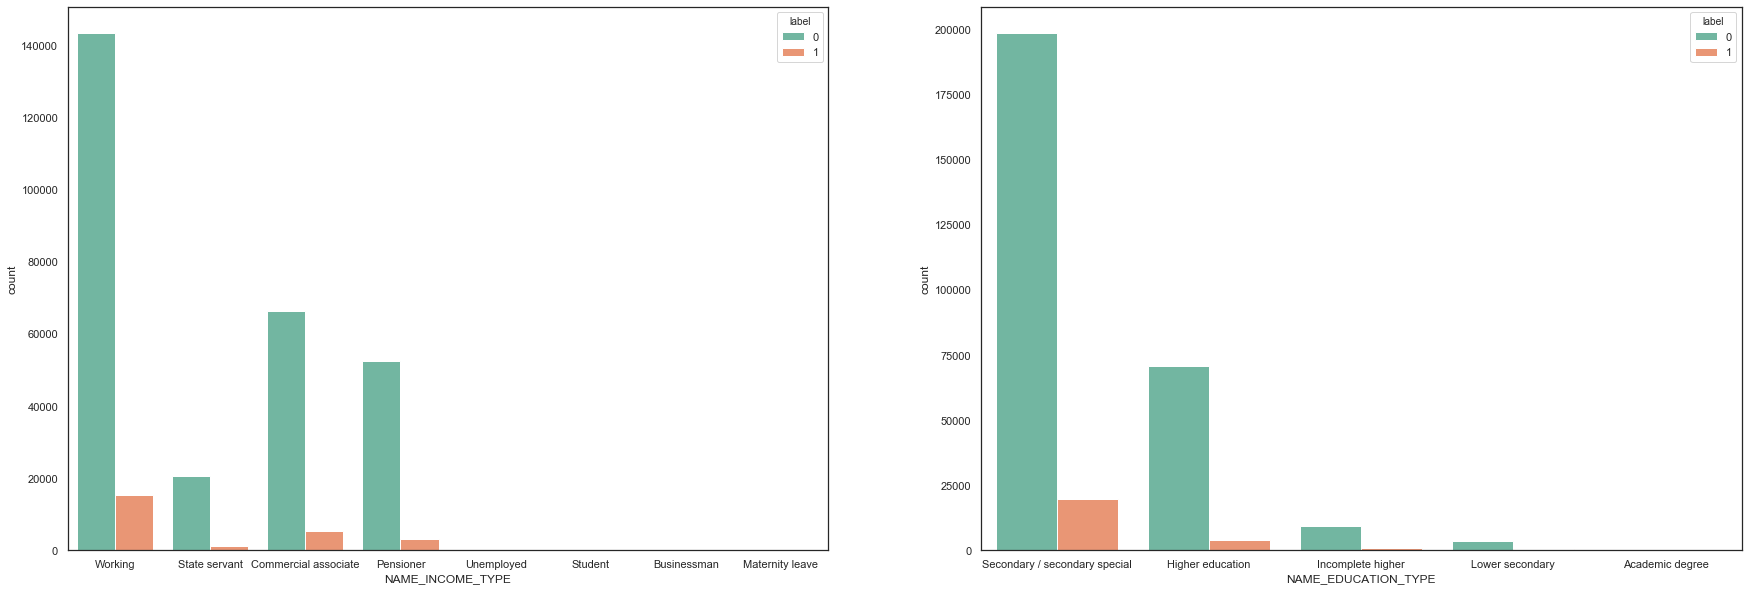

In [17]:
f, axes = plt.subplots(1, 2, figsize=(30, 10))
ax = sns.countplot(x="NAME_INCOME_TYPE", hue="label", data=loan_history_df_pandas, palette="Set2", ax=axes[0])
ax = sns.countplot(x="NAME_EDUCATION_TYPE", hue="label", data=loan_history_df_pandas, palette="Set2", ax=axes[1])

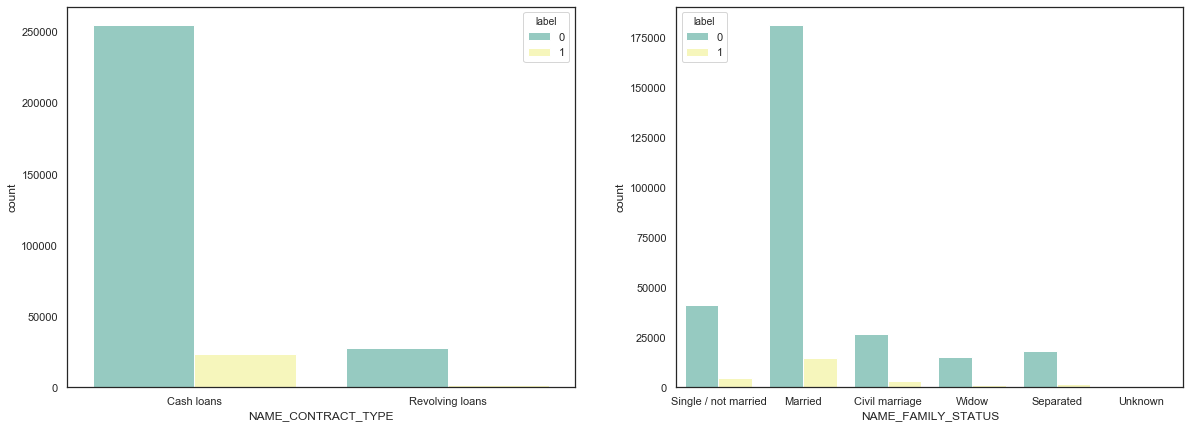

In [18]:
f, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.countplot(x="NAME_CONTRACT_TYPE", hue="label", data=loan_history_df_pandas, palette="Set3", ax=axes[0])
sns.countplot(x="NAME_FAMILY_STATUS", hue="label", data=loan_history_df_pandas, palette="Set3", ax=axes[1])

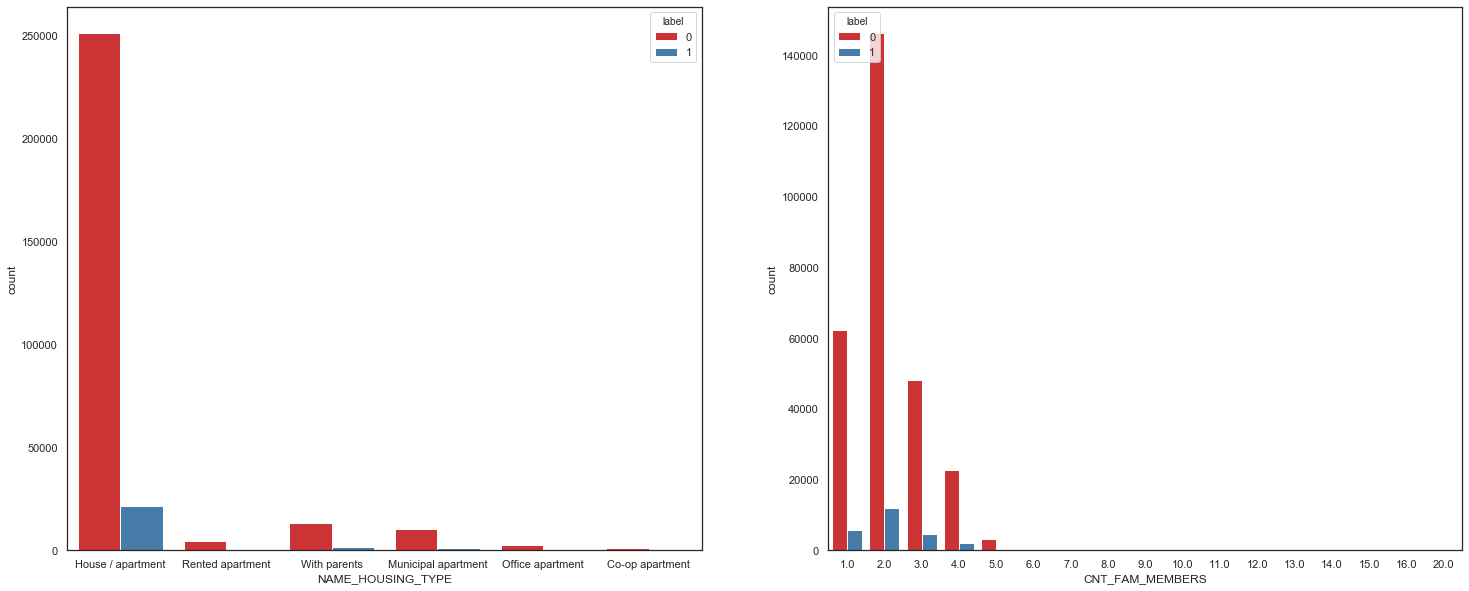

In [19]:
f, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.countplot(x="NAME_HOUSING_TYPE", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[0])
sns.countplot(x="CNT_FAM_MEMBERS", hue="label", data=loan_history_df_pandas, palette="Set1", ax=axes[1])

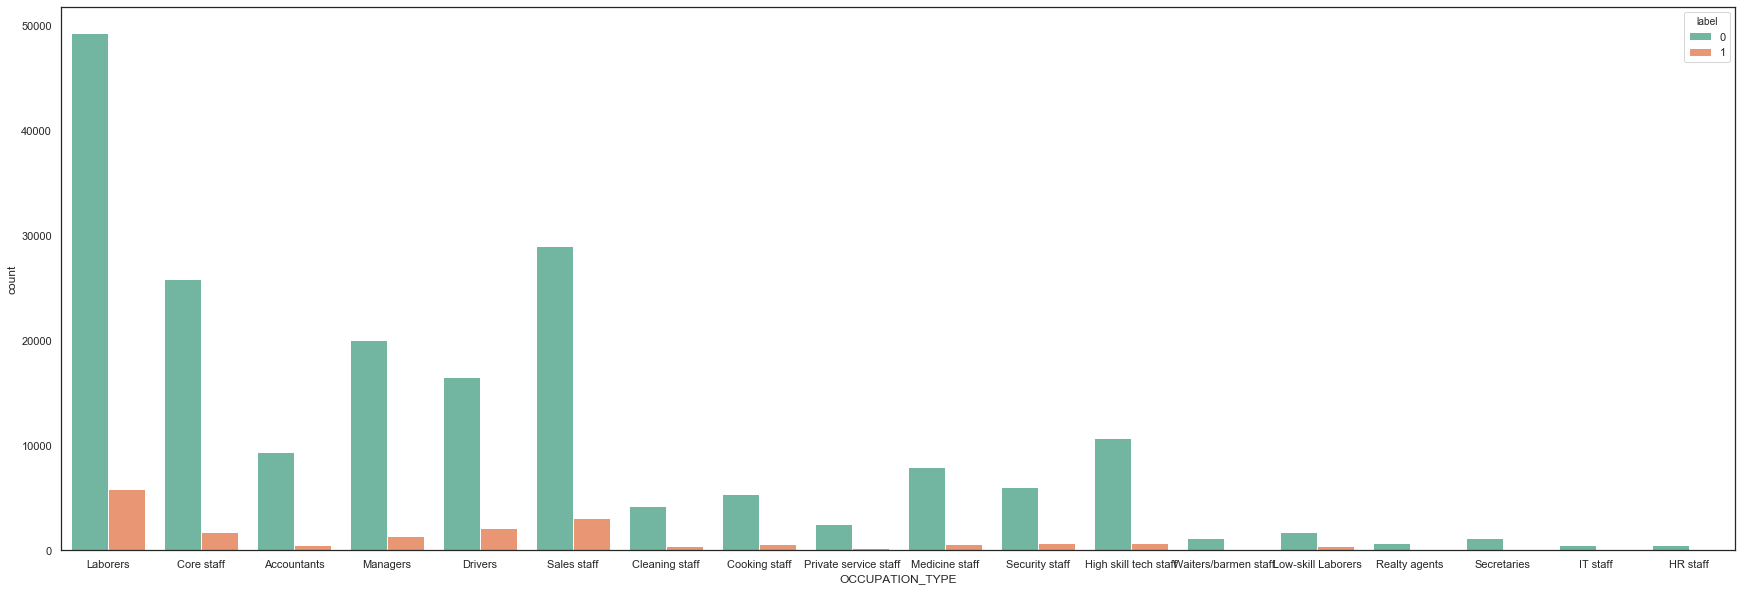

In [20]:
f, axes = plt.subplots(1, 1, figsize=(30, 10))
sns.countplot(x="OCCUPATION_TYPE", hue="label", data=loan_history_df_pandas, palette="Set2", axes = axes)

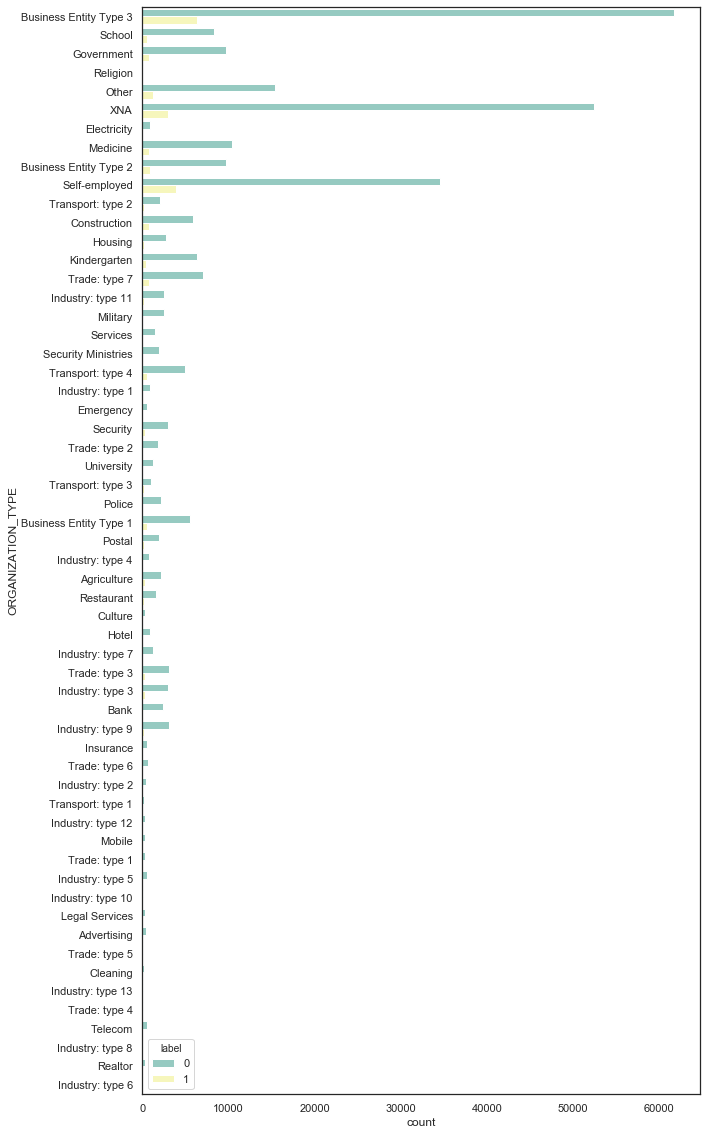

In [21]:
f, axes = plt.subplots(1, 1, figsize=(10, 20))
sns.countplot(y="ORGANIZATION_TYPE", hue="label", data=loan_history_df_pandas, palette="Set3", ax=axes)

<Figure size 720x864 with 0 Axes>

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Distribution of EXT_SOURCE_1 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_1')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_2 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_2')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_3 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_3')

Text(0, 0.5, 'Density')

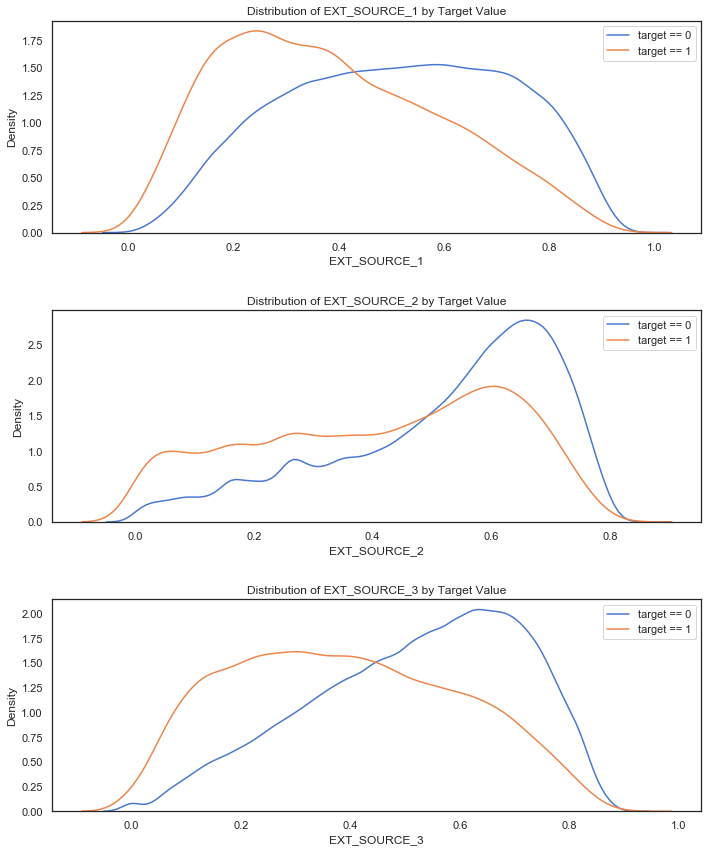

In [22]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(loan_history_df_pandas.loc[loan_history_df_pandas['label'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(loan_history_df_pandas.loc[loan_history_df_pandas['label'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

<p>
    EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time
    
</p>

,label,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
label,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,...,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,-0.239818,0.183395,...,0.004031,0.000864,0.000988,-0.002450,-0.000410,-0.000366,-0.002436,-0.010808,-0.007836,-0.041550
AMT_INCOME_TOTAL,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,-0.064223,0.027805,...,0.003130,0.002408,0.000242,-0.000589,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690
AMT_CREDIT,-0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.066838,0.009621,...,0.034329,0.021082,0.031023,-0.016148,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
AMT_ANNUITY,-0.012817,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,-0.104332,0.038514,...,-0.009745,0.004573,0.011718,-0.017598,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.002704,-0.000366,0.002944,0.004238,0.002185,0.004677,0.001399,0.002255,0.000472,-0.000508,...,0.013281,0.001126,-0.000120,-0.001130,0.230374,1.000000,0.217412,-0.005258,-0.004416,-0.003355
AMT_REQ_CREDIT_BUREAU_WEEK,0.000788,-0.002436,0.002387,-0.001275,0.013881,-0.001007,-0.002149,-0.001336,0.003072,-0.001069,...,-0.004640,-0.001275,-0.001770,0.000081,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917
AMT_REQ_CREDIT_BUREAU_MON,-0.012462,-0.010808,0.024700,0.054451,0.039148,0.056422,0.078607,0.001372,-0.034457,-0.011353,...,-0.001565,-0.002729,0.001285,-0.003612,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975
AMT_REQ_CREDIT_BUREAU_QRT,-0.002022,-0.007836,0.004859,0.015925,0.010124,0.016432,-0.001279,-0.011799,0.015345,-0.001308,...,-0.005125,-0.001575,-0.001010,-0.002004,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208


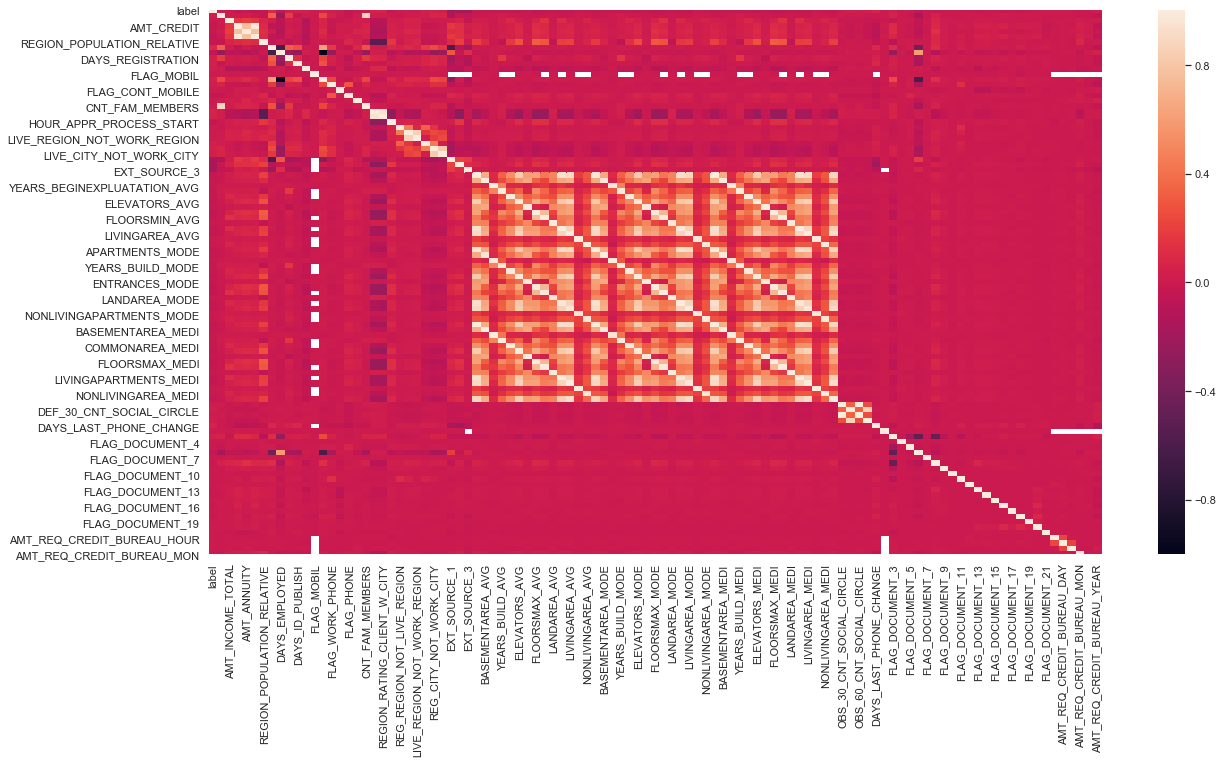

In [23]:
correlation_table = loan_history_df_pandas.corr(method='pearson')
correlation_table
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(correlation_table, ax=axes)

In [24]:
# now let's see how many categorical and numeirical features we have:
cat_cols = [item[0] for item in loan_history_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in loan_history_df.dtypes 
            if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

16  categorical features
104  numerical features


In [25]:
# we use the below function to find more information about the #missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    return mis_val_table_ren_columns

In [26]:
missings = info_missing_table(loan_history_df_pandas)
missings

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [27]:
cat_cols_with_missing = np.intersect1d(np.array(missings.index), cat_cols)
num_cols_with_missing = np.intersect1d(np.array(missings.index), num_cols)

In [28]:
# we will fill the missing numerical column values with the mean of the column
df_Nomiss=loan_history_df.na.drop()
for x in cat_cols_with_missing:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode, sep = ':')
    loan_history_df = loan_history_df.na.fill({x:mode})
# we will fill the missing categorical values with the most frequent category
for i in num_cols_with_missing:
    meanvalue = loan_history_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue, sep = ':') 
    loan_history_df=loan_history_df.na.fill({i:meanvalue})

EMERGENCYSTATE_MODE:No
FONDKAPREMONT_MODE:reg oper account
HOUSETYPE_MODE:block of flats
NAME_TYPE_SUITE:Unaccompanied
OCCUPATION_TYPE:Laborers
WALLSMATERIAL_MODE:Panel
AMT_ANNUITY:27109.0
AMT_GOODS_PRICE:538396.0
AMT_REQ_CREDIT_BUREAU_DAY:0.0
AMT_REQ_CREDIT_BUREAU_HOUR:0.0
AMT_REQ_CREDIT_BUREAU_MON:0.0
AMT_REQ_CREDIT_BUREAU_QRT:0.0
AMT_REQ_CREDIT_BUREAU_WEEK:0.0
AMT_REQ_CREDIT_BUREAU_YEAR:2.0
APARTMENTS_AVG:0.0
APARTMENTS_MEDI:0.0
APARTMENTS_MODE:0.0
BASEMENTAREA_AVG:0.0
BASEMENTAREA_MEDI:0.0
BASEMENTAREA_MODE:0.0
CNT_FAM_MEMBERS:2.0
COMMONAREA_AVG:0.0
COMMONAREA_MEDI:0.0
COMMONAREA_MODE:0.0
DAYS_LAST_PHONE_CHANGE:-963.0
DEF_30_CNT_SOCIAL_CIRCLE:0.0
DEF_60_CNT_SOCIAL_CIRCLE:0.0
ELEVATORS_AVG:0.0
ELEVATORS_MEDI:0.0
ELEVATORS_MODE:0.0
ENTRANCES_AVG:0.0
ENTRANCES_MEDI:0.0
ENTRANCES_MODE:0.0
EXT_SOURCE_1:1.0
EXT_SOURCE_2:1.0
EXT_SOURCE_3:1.0
FLOORSMAX_AVG:0.0
FLOORSMAX_MEDI:0.0
FLOORSMAX_MODE:0.0
FLOORSMIN_AVG:0.0
FLOORSMIN_MEDI:0.0
FLOORSMIN_MODE:0.0
LANDAREA_AVG:0.0
LANDAREA_MEDI:0.0
LA

In [29]:
loan_history_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


In [30]:
minority_class_df = loan_history_df.filter("label=1")
majority_class_df = loan_history_df.filter("label=0")

# Under-sampling the majority class
sampleRatio = minority_class_df.count() / loan_history_df.count()
majority_class_sample_df = majority_class_df.sample(sampleRatio)

balanced_loan_history = minority_class_df.union(majority_class_sample_df)

In [31]:
balanced_loan_history.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,22937


In [32]:
stages = []

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cat_cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

allFeatureColumns = []
allFeatureColumns.extend([encoder.getOutputCol() for encoder in encoders])
allFeatureColumns.extend(num_cols)

assembler = VectorAssembler(
    inputCols=allFeatureColumns,
    outputCol="features"
)

stages.extend(indexers)
stages.extend(encoders)
stages.append(assembler)

pipeline = Pipeline(stages=stages)
loan_history_features = pipeline.fit(balanced_loan_history).transform(balanced_loan_history)

train, test = loan_history_features.randomSplit([0.80, 0.20], seed = 42)

print(train.count())
print(test.count())

38394
9368


In [34]:
modelsAndROCs = []

Text(0, 0.5, 'False Positive Rate')

Text(0.5, 0, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

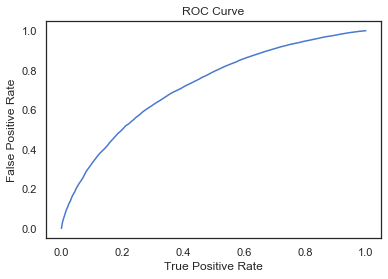

Training set ROC: 0.7199089998687564


In [35]:
# first we check how LogisticRegression perform 
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [36]:
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
LR_ROC = evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})
print("Test_SET (Area Under ROC): " + str(LR_ROC))
modelsAndROCs.append(("Logistic Regression", LR_ROC))

Test_SET (Area Under ROC): 0.7207754139532166


In [37]:
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7384080094836899


In [38]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 15])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
gbt_cv_predictions = cvModel.transform(test)
GBT_ROC = evaluator.evaluate(gbt_cv_predictions)
modelsAndROCs.append(("Gradient Boosted Trees", GBT_ROC))
GBT_ROC

0.733848021858482

In [39]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20, maxDepth=2, seed=42)
rf_model = rf.fit(train)
predictions_rf = rf_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6891706197251994


In [40]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [1, 2])
             .addGrid(rf.numTrees, [5, 50])
             .build())
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
rf_cv_predictions = cvModel.transform(test)
RF_ROC = evaluator.evaluate(rf_cv_predictions)
modelsAndROCs.append(("Random Forest", RF_ROC))
RF_ROC

0.7059658634611452

In [41]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [42]:
feature_imp_df = ExtractFeatureImp(rf_model.featureImportances, rf_cv_predictions, "features")
feature_imp_df

,idx,name,score
29,150,EXT_SOURCE_3,0.144077
28,149,EXT_SOURCE_2,0.137255
4,125,AMT_GOODS_PRICE,0.099454
6,127,DAYS_BIRTH,0.095567
114,10,NAME_INCOME_TYPE_indexed_encoded_Working,0.067296
...,...,...,...
88,209,FLAG_DOCUMENT_12,0.000000
89,210,FLAG_DOCUMENT_13,0.000000
90,211,FLAG_DOCUMENT_14,0.000000
91,212,FLAG_DOCUMENT_15,0.000000


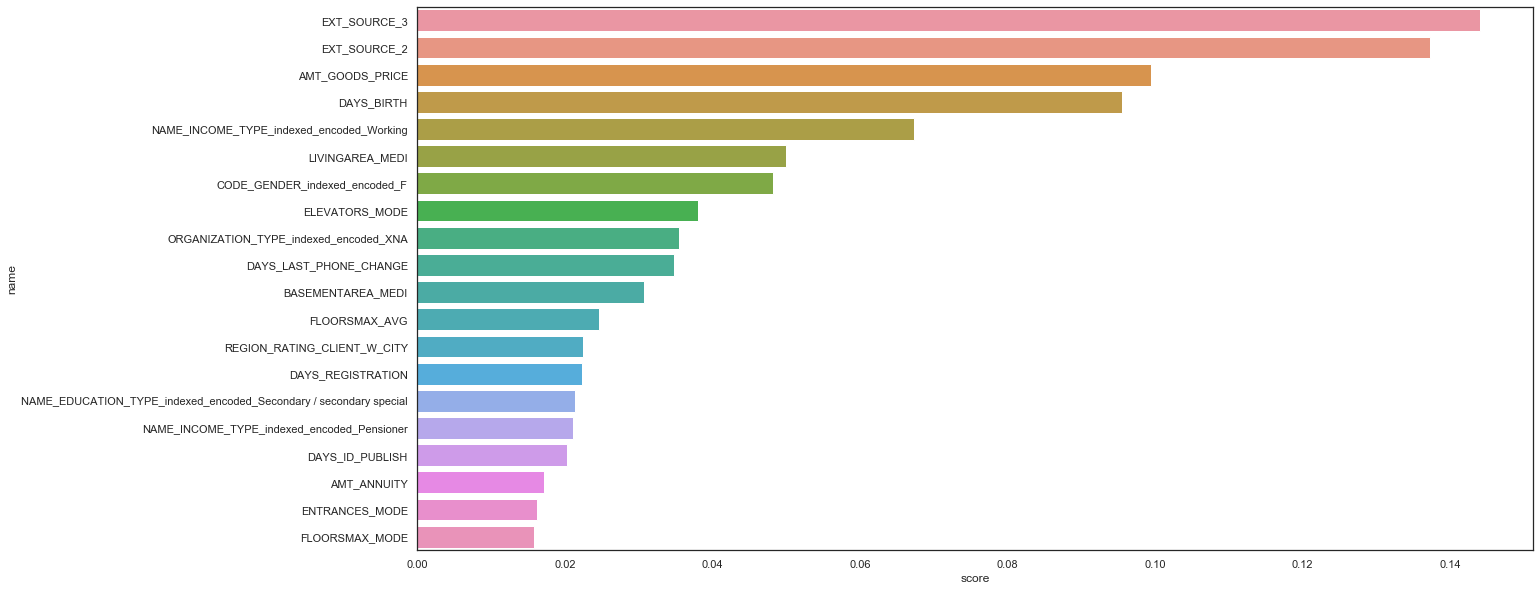

In [43]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x="score", y="name", data=feature_imp_df.head(20), ax=axes)

In [44]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=2, seed=42)
dt_model = dt.fit(train)
predictions_dt = dt_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.5827945675028472


In [45]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 5])
             .addGrid(dt.minInstancesPerNode, [5, 10])
             .build())
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
dt_cv_predictions = cvModel.transform(test)
DT_ROC = evaluator.evaluate(dt_cv_predictions)
modelsAndROCs.append(("Decision Tree", DT_ROC))
DT_ROC

0.6139406229010309

In [46]:
no_of_features = loan_history_features.schema["features"].metadata["ml_attr"]["num_attrs"]
layers = [no_of_features,100,60,30,2]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, seed=123, solver='gd')
mpc_model = mlp.fit(train)
predictions_mpc = mpc_model.transform(test)

predictionAndLabels = predictions_mpc.select("prediction", "label")
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label',  metricName='areaUnderROC')
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictionAndLabels)))

Test_SET (Area Under ROC): 0.5078990596618287


In [47]:
mlp = MultilayerPerceptronClassifier(maxIter=100, seed=42)
paramGrid = (ParamGridBuilder()
             .addGrid(mlp.solver, ['gd', 'l-bfgs'])
             .addGrid(mlp.layers, [[no_of_features,75,25,2], [no_of_features,50,15,2]])
             .build())
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=mlp, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)
mlp_cv_predictions = cvModel.transform(test)
MLP_ROC = evaluator.evaluate(mlp_cv_predictions)
modelsAndROCs.append(("Multilayer Perceptron", MLP_ROC))
MLP_ROC

0.5657635091478551

,Model,ROC
0,Logistic Regression,0.720775
1,Gradient Boosted Trees,0.733848
2,Random Forest,0.705966
3,Decision Tree,0.613941
4,Multilayer Perceptron,0.565764


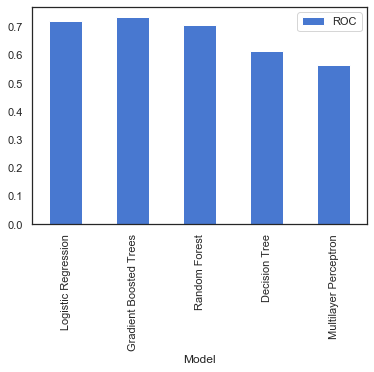

In [60]:
modelsAndROCsDf = pd.DataFrame(data = modelsAndROCs, columns=['Model', 'ROC'])
modelsAndROCsDf
ax = modelsAndROCsDf.plot.bar(x='Model', y='ROC')